## Risk analysis

We want to solve the problem:
\begin{align*}
&\min_{Q_C,Q} OF=P_CQ_C+\widetilde{P} Q\\
&\rm{s.t.}\\
&\quad Q_C+Q \geq \widetilde{D} \\
&\quad 0\leq Q_C \leq Q_C^{max}\\
&\quad Q \geq 0 
\end{align*}

where $\widetilde{P}$ and $\widetilde{D}$ are correlated random variables (lets assume normal).

We also assume that $P_C=45$ and $Q_c^{max}=90$

Lets generate random correlated scenarios for these variables:

<IPython.core.display.Javascript object>


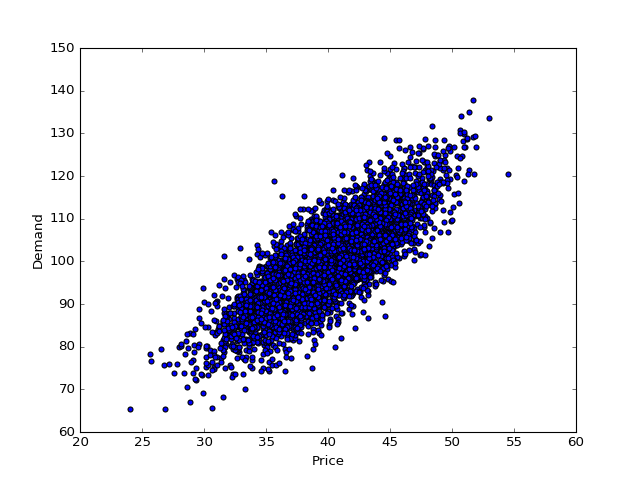

(<matplotlib.collections.PathCollection at 0x7f176d84ff90>,
 <matplotlib.text.Text at 0x7f176d8738d0>)

In [5]:
%matplotlib notebook
from __future__ import division 
import numpy as np
import matplotlib.pyplot as plt


n_sc=5000;

means = np.array([40,100]) #mean for the price and the demand, Expected value for the price
                            #Expected value for the demand is 100

vr   = 0.1 #10%  level of dispersion of the escenario

#Standar deviation
stds = np.array( [means[0]*vr, means[1]*vr ] )

#Correlation
corr = 0.8             # Value he decided

#Covariance matrix
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, n_sc).T

# #data

Pc    = 45
Qcmax = 90
Pw    = m[0]
Dw    = m[1]
piw   = (1/n_sc) * np.ones(n_sc)

##########
alpha=0.8 #this is for the CVaR problem
#########


plt.figure()
plt.scatter(m[0], m[1]),plt.xlabel('Price'),plt.ylabel('Demand')

## Stochastic program: Expecte value

Consider the problem:

\begin{align*}
&\min_{Q_C,Q_\omega} OF=P_CQ_C+\sum_{\omega=1}^{\Omega}\pi_{\omega}P_{\omega} Q_{\omega}\\
&\rm{s.t.}\\
&\quad Q_C+Q_{\omega}\geq D_{\omega} \quad \forall \omega \\
&\quad 0\leq Q_C \leq Q_C^{max}\\
&\quad Q_{\omega} \geq 0 \qquad \qquad \forall \omega
\end{align*}

where $\pi_{\omega}$ is the probability associated with each scenario $\omega=1,\dots,\Omega$

We assume equiprobable scenarios so that $\pi_{\omega}=\frac{1}{\Omega}$.

The stochastic problem formulation is:

In [9]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

modelsc = AbstractModel()

modelsc.w = RangeSet(1,n_sc)#scenarios

#model variables: continuous
modelsc.Qc = Var(domain=NonNegativeReals) #contract quantity
modelsc.Qw = Var(modelsc.w, domain=NonNegativeReals) #market quantity
#modelsc.Qw = Var(modelsc.w) #market quantity, allows arbitrage

#definition of the objective function
def Obj_rule(modelsc):
	return Pc*modelsc.Qc+sum(piw[w-1]*Pw[w-1]*modelsc.Qw[w] for w in modelsc.w)
modelsc.Obj = Objective(rule=Obj_rule, sense=minimize)

#constraint min demand
def min_dem(modelsc,w): 
	return modelsc.Qc+modelsc.Qw[w] >= Dw[w-1]
modelsc.min_dem_cons = Constraint(modelsc.w, rule=min_dem)

#constraint max contract
def max_cont(modelsc): 
	return modelsc.Qc <= Qcmax  
modelsc.max_cont_cons = Constraint(rule=max_cont)


In [11]:
#from coopr.pyomo import value
instancesc = modelsc.create_instance()
#instance.pprint()
resultsc = opt.solve(instancesc)
OFsc=instancesc.Obj()
print(OFsc)
print(instancesc.Qc())

4030.28486564
0.0


<ul>
<li> Now we run the model and compute the costs per scenario.</li>
<li> We plot the resulting <b>histogram</b></li>
</ul>

<IPython.core.display.Javascript object>


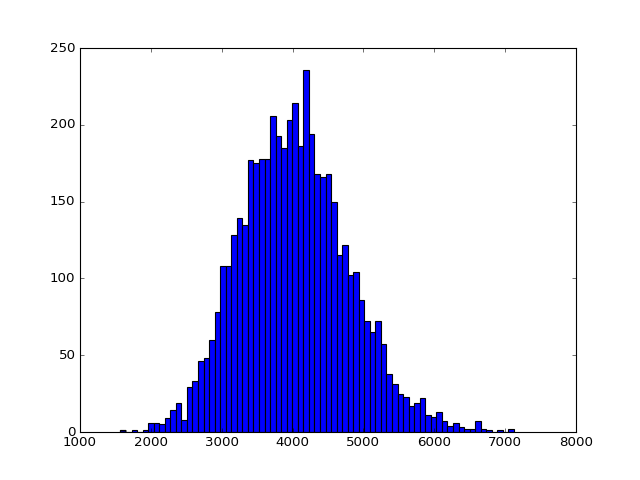

0.0
4030.28486564
4030.28486564


/home/alessandro/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/alessandro/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


In [12]:
#quantities
Qcontsc=instancesc.Qc()
Qwsc=np.ones(n_sc)
for i in range(1,n_sc+1):
    Qwsc[i-1]= instancesc.Qw[i].value #Store each scenario
    
#costs per scenario
Costsc = Pc*Qcontsc + Pw * Qwsc   #Vector of Cost

#plot the histogram
plt.figure()
plt.hist(Costsc,np.round_(np.sqrt(n_sc)))
print(Qcontsc)
print(OFsc)
print(np.mean(Costsc))

## Stochastic program: Conditional Value at Risk (CVaR)

Consider the problem:

\begin{align*}
&\min_{Q_C,Q_\omega,\xi,\eta_{\omega}} CVaR=\xi+\frac{1}{1-\alpha}\sum_{\omega=1}^{\Omega}\pi_{\omega}\eta_{\omega}\\
&\rm{s.t.}\\
&\quad -\Pi_{\omega}+\xi+\eta_{\omega}\geq 0\qquad \qquad \forall \omega \\
&\quad \eta_{\omega} \geq 0\qquad \qquad \qquad \qquad \forall \omega \\
&\quad \Pi_{\omega}=P_CQ_C+P_{\omega} Q_{\omega}\quad \forall{\omega}\\
&\quad Q_C+Q_{\omega}\geq D_{\omega} \quad \qquad \qquad \forall \omega \\
&\quad 0\leq Q_C \leq Q_C^{max}\\
&\quad Q_{\omega} \geq 0 \qquad \qquad \qquad \qquad \forall \omega
\end{align*}

where $\eta$ and $\xi_{\omega}$ areauxiliary variables. In particular, at the optimal solution $\xi=$VaR$_{\alpha}$  
The CVaR problem formulation is:

In [13]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

modelcv = AbstractModel()


modelcv.w = RangeSet(1,n_sc)#scenarios

#model variables: continuous
modelcv.Qc = Var(domain=NonNegativeReals) #contract quantity
modelcv.Qw = Var(modelcv.w, domain=NonNegativeReals) #market quantity
#modelcv.Qw = Var(modelcv.w) #market quantity, allows arbitrage as Qw can be negative

modelcv.eta = Var(modelcv.w, domain=NonNegativeReals) #cvar auxiliary variable
modelcv.Costcv = Var(modelcv.w) #cvar auxiliary variable
modelcv.xi = Var() #cvar auxiliary variable

#definition of the objective function

def Obj_rule_cv(modelcv):
	return modelcv.xi+ (1/(1-alpha))*sum(piw[w-1]*modelcv.eta[w] for w in modelcv.w) 
modelcv.Obj = Objective(rule=Obj_rule_cv, sense=minimize)

#constraint CVaR
def cvar_cons(modelcv,w): 
	return -modelcv.Costcv[w]+modelcv.xi+modelcv.eta[w] >= 0  
modelcv.cvar_cons_cv = Constraint(modelcv.w, rule=cvar_cons)

#definition of costs per scenario
def costcv_cons(modelcv,w):
	return modelcv.Costcv[w]-Pc*modelcv.Qc-Pw[w-1]*modelcv.Qw[w] == 0 
modelcv.costcv_cons_cons = Constraint(modelcv.w, rule=costcv_cons)

#constraint min demand
def min_demcv(modelcv,w): 
	return modelcv.Qc+modelcv.Qw[w] >= Dw[w-1]  
modelcv.min_dem_cons = Constraint(modelcv.w, rule=min_demcv)

#constraint max contract
def max_contcv(modelcv): 
	return modelcv.Qc <= Qcmax  
modelcv.max_cont_cons = Constraint(rule=max_contcv)

<ul>
<li> Now we run the model and compute the costs per scenario.</li>
<li> We plot the resulting <b>histogram</b></li>
</ul>

<IPython.core.display.Javascript object>


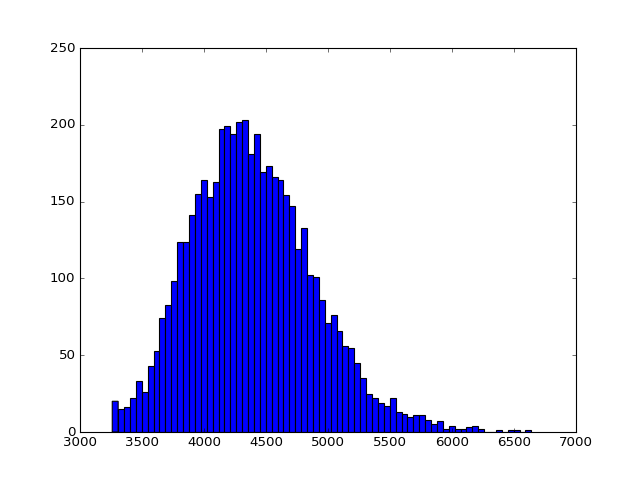

72.4464038749
5124.3995249
4394.07336108


In [14]:
#from coopr.pyomo import value
instancecv = modelcv.create_instance()
#instance.pprint()
resultcv = opt.solve(instancecv)
#instancecv.load(resultcv)

#objective function
OFcv=instancecv.Obj()
#quantities
Qcontcv=instancecv.Qc()
Qwcv=np.ones(n_sc)
for i in range(1,n_sc+1):
    Qwcv[i-1]=instancecv.Qw[i].value
#costs per scenario
Costcv=Pc*Qcontcv+Pw*Qwcv
#plot the histogram
plt.figure()
plt.hist(Costcv,np.round_(np.sqrt(n_sc)))
print(Qcontcv)
print(OFcv)
print(np.mean(Costcv))

## Worst Case Analysis

Consider the problem:

\begin{align*}
&\min_{Q_C,Q_\omega} t\\
&\rm{s.t.}\\
&\quad P_CQ_C+P_{\omega} Q_{\omega} \leq t \quad\forall \omega\\
&\quad Q_C+Q_{\omega}\geq D_{\omega} \quad \forall \omega \\
&\quad 0\leq Q_C \leq Q_C^{max}\\
&\quad Q_{\omega} \geq 0 \qquad \qquad \forall \omega
\end{align*}

where $\pi_{\omega}$ is the probability associated with each scenario $\omega=1,\dots,\Omega$

We assume equiprobable scenarios so that $\pi_{\omega}=\frac{1}{\Omega}$.

The worst case formulation is:

In [15]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

modelwc = AbstractModel()

modelwc.w = RangeSet(1,n_sc)#scenarios

#model variables: continuous
modelwc.t = Var() #worst case cost scenario
modelwc.Qc = Var(domain=NonNegativeReals) #contract quantity
modelwc.Qw = Var(modelwc.w, domain=NonNegativeReals) #market quantity
#modelwc.Qw = Var(modelwc.w) #market quantity, allows arbitrage

#definition of the objective function

def Obj_rule(modelwc):
	return modelwc.t   
modelwc.Obj = Objective(rule=Obj_rule, sense=minimize)

#constraint worst case
def worst_case(modelwc,w): 
	return Pc*modelwc.Qc + Pw[w-1]*modelwc.Qw[w] <= modelwc.t    
modelwc.worst_case_cons = Constraint(modelwc.w, rule=worst_case)

#constraint min demand
def min_dem(modelwc,w): 
	return modelwc.Qc + modelwc.Qw[w] >= Dw[w-1]
modelwc.min_dem_cons = Constraint(modelwc.w, rule=min_dem)

#constraint max contract
def max_cont(modelwc): 
	return modelwc.Qc <= Qcmax  
modelwc.max_cont_cons = Constraint(rule=max_cont)

<IPython.core.display.Javascript object>


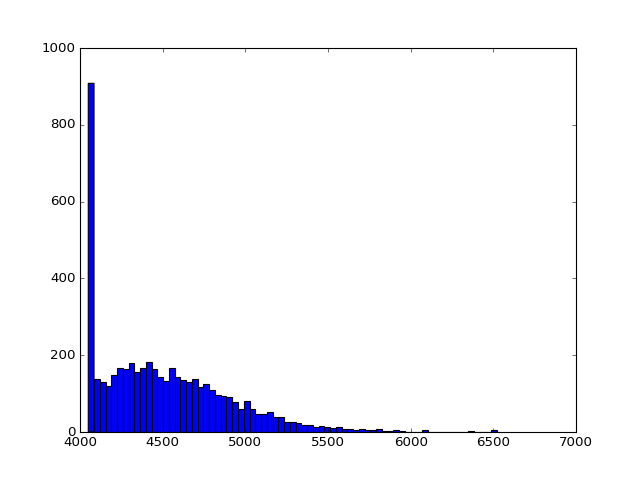

90.0
6522.83614243
4509.2229848


In [16]:
#from coopr.pyomo import value
instancewc = modelwc.create_instance()
#instance.pprint()
resultwc = opt.solve(instancewc)
#instancewc.load(resultwc)

#objective function
OFwc=instancewc.Obj()
#quantities
Qcontwc=instancewc.Qc()
Qwwc=np.ones(n_sc)
for i in range(1,n_sc+1):
    Qwwc[i-1]=instancewc.Qw[i].value
#costs per scenario
Costwc=Pc*Qcontwc+Pw*Qwwc
#plot the histogram
plt.figure()
plt.hist(Costwc,np.round_(np.sqrt(n_sc)))
print(Qcontwc)
print(OFwc)
print(np.mean(Costwc))

## Comparison of histograms

<IPython.core.display.Javascript object>


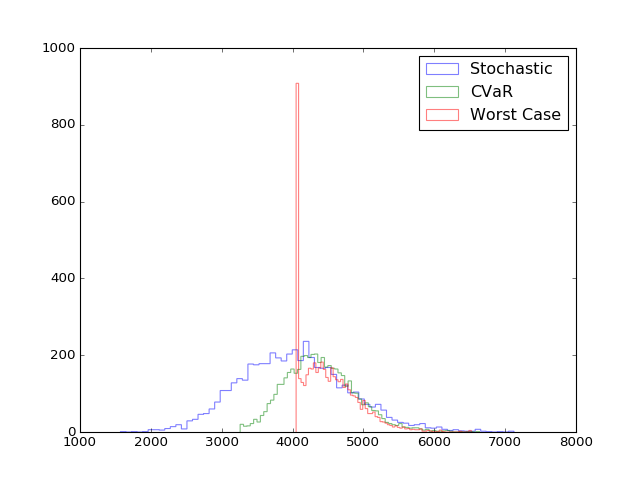

In [17]:
plt.figure()
bins=np.round_(np.sqrt(n_sc))
plt.hist(Costsc, bins, alpha=0.5, histtype = 'step',label='Stochastic')
plt.hist(Costcv, bins, alpha=0.5, histtype = 'step',label='CVaR')
plt.hist(Costwc, bins, alpha=0.5, histtype = 'step',label='Worst Case')
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


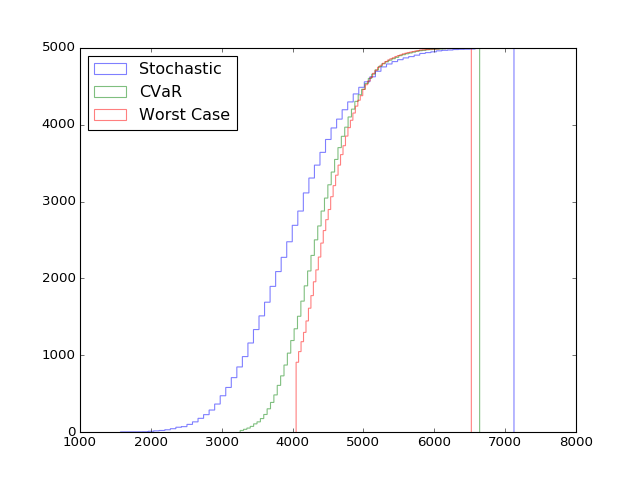

In [18]:
plt.figure()
plt.hist(Costsc, bins, alpha=0.5,cumulative=True,histtype = 'step', label='Stochastic')
plt.hist(Costcv, bins, alpha=0.5, cumulative=True,histtype = 'step',label='CVaR')
plt.hist(Costwc, bins, alpha=0.5, cumulative=True,histtype = 'step',label='Worst Case')
plt.legend(loc='upper left')
plt.show()

In [19]:
print(np.max(Costsc))
print(np.max(Costcv))
print(np.max(Costwc))

7124.6454356
6640.21300106
6522.83614243
